In [1]:
import sys; sys.path.append('..')

import pandas as pd
import matplotlib.pyplot as plt

from common.polymarket import (
    fetch_event,
    filter_markets_by_volume,
    fetch_price_history,
    load_single_market_data,
    save_market_data,
)

In [ ]:
EVENT_ID = 903193  # 2024 US Presidential Election
# EVENT_ID = 12641  # TikTok banned in the US before May 2025?
# EVENT_ID = 17088  # Ukraine war will end before July 2025?
# EVENT_ID = 13551  # Trump end war in Ukraine first 90 days?
# EVENT_ID = 11322  # 

event = fetch_event(EVENT_ID)

print(f"Event: {event['title']}")
print(f"Total markets: {len(event['markets'])}")
print(f"Event period: {event['startDate']} → {event['endDate']}")

Event: Presidential Election Winner 2024
Total markets: 17
Event period: 2024-01-04T22:58:00Z → 2024-11-05T12:00:00Z


In [ ]:
filtered_markets = filter_markets_by_volume(event, threshold_pct=0.05)

print(f"Filtered to {len(filtered_markets)} markets (>5% volume):\n")
for m in filtered_markets:
    print(f"{m['question'][:60]}")
    print(f"  Volume: ${m['volume']:,.0f}\n")

Filtered to 3 markets (>5% volume):

Will Donald Trump win the 2024 US Presidential Election?
  Volume: $1,531,479,285

Will Kamala Harris win the 2024 US Presidential Election?
  Volume: $1,037,039,118

Will any other Republican Politician win the 2024 US Preside
  Volume: $241,655,100



In [4]:
start_date = pd.to_datetime(event['startDate'], utc=True)
end_date = pd.to_datetime(event['endDate'], utc=True)

all_market_data = {}

for market in filtered_markets:
    data = fetch_price_history(market['token_id'], start_date, end_date)
    all_market_data[market['question']] = data
    print(f"{market['question'][:50]}: {len(data['times'])} points")

Will Donald Trump win the 2024 US Presidential Ele: 439803 points
Will Kamala Harris win the 2024 US Presidential El: 439715 points
Will any other Republican Politician win the 2024 : 437120 points


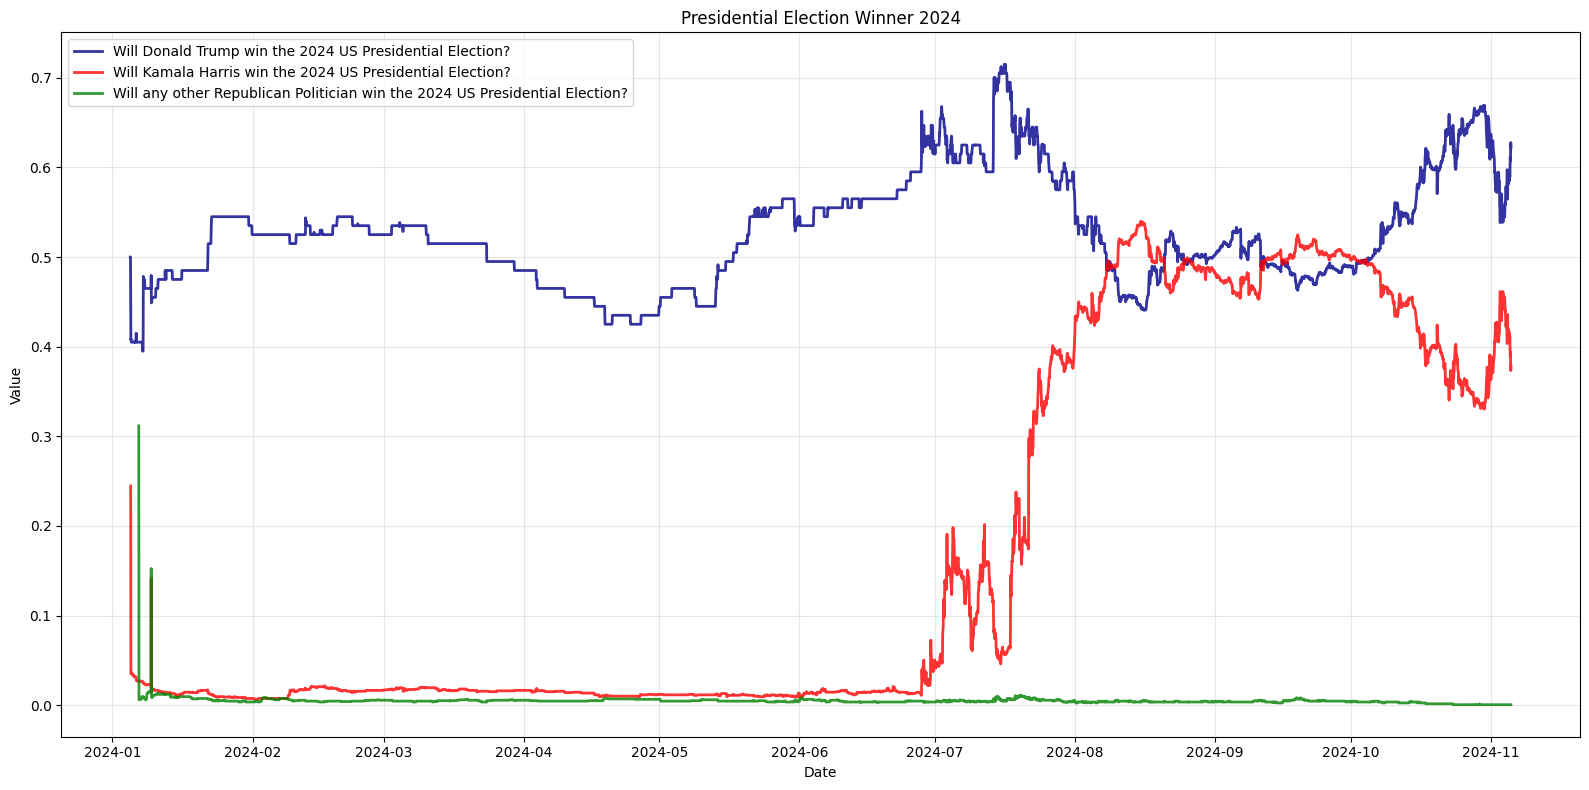

In [5]:
plt.figure(figsize=(16, 8))

colors = ['darkblue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']

for idx, (question, data) in enumerate(all_market_data.items()):
    if len(data['times']) > 0:
        df_temp = pd.DataFrame({'time': data['times'], 'price': data['prices']})
        df_temp['hour'] = df_temp['time'].dt.floor('h')
        hourly = df_temp.groupby('hour')['price'].mean()

        plt.plot(hourly.index, hourly.values, linewidth=2, label=question, color=colors[idx % len(colors)], alpha=0.8)


plt.xlabel('Date')
plt.ylabel('Value')
plt.title(event['title'])
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
import json

data_to_save = {
    'event': {
        'id': EVENT_ID,
        'title': event['title'],
        'start_date': start_date.isoformat(),
        'end_date': end_date.isoformat(),
    },
    'markets': filtered_markets,
    'price_data': {
        question: {
            'times': [t.isoformat() for t in data['times']],
            'prices': data['prices']
        }
        for question, data in all_market_data.items()
    }
}

with open(f'../data/{event["slug"]}.json', 'w') as f:
    json.dump(data_to_save, f, indent=2)

print(f"Saved to ../data/{event['slug']}.json")
print(f"  Event: {event['slug']}")
print(f"  Markets: {len(filtered_markets)}")
print(f"  Data points: {sum(len(d['times']) for d in all_market_data.values()):,}")

Saved to ../data/trump-wins-ends-ukraine-war-in-90-days.json
  Event: trump-wins-ends-ukraine-war-in-90-days
  Markets: 1
  Data points: 258,658


## Batch: Load and save data for multiple events/markets

In [2]:
events = [
    (903193, "21742633143463906290569050155826241533067272736897614950488156847949938836455"), # Will Trump will 2024 US Elections
    (903193, "69236923620077691027083946871148646972011131466059644796654161903044970987404"), # Will Kamala will 2024 US Elections
    (13551, "84888738552927367074645370589243532246434846262240067551074642775011167355434"), # Trump ends Ukraine war in first 90 days?
    (21257, "72188521528281725530941480263471548998870917094570869557644274272141820605818"), # Israel x Hamas ceasefire before July 2025?
    (12641, "24635636911615866092589652362670811323984202357282728474473612545495782013438"), # TikTok banned in the US before May 2025?
]

Fetching price history: 100%|██████████| 44/44 [00:19<00:00,  2.23chunk/s, points=439803]


Loaded 439,803 price points for: Will Donald Trump win the 2024 US Presidential Ele


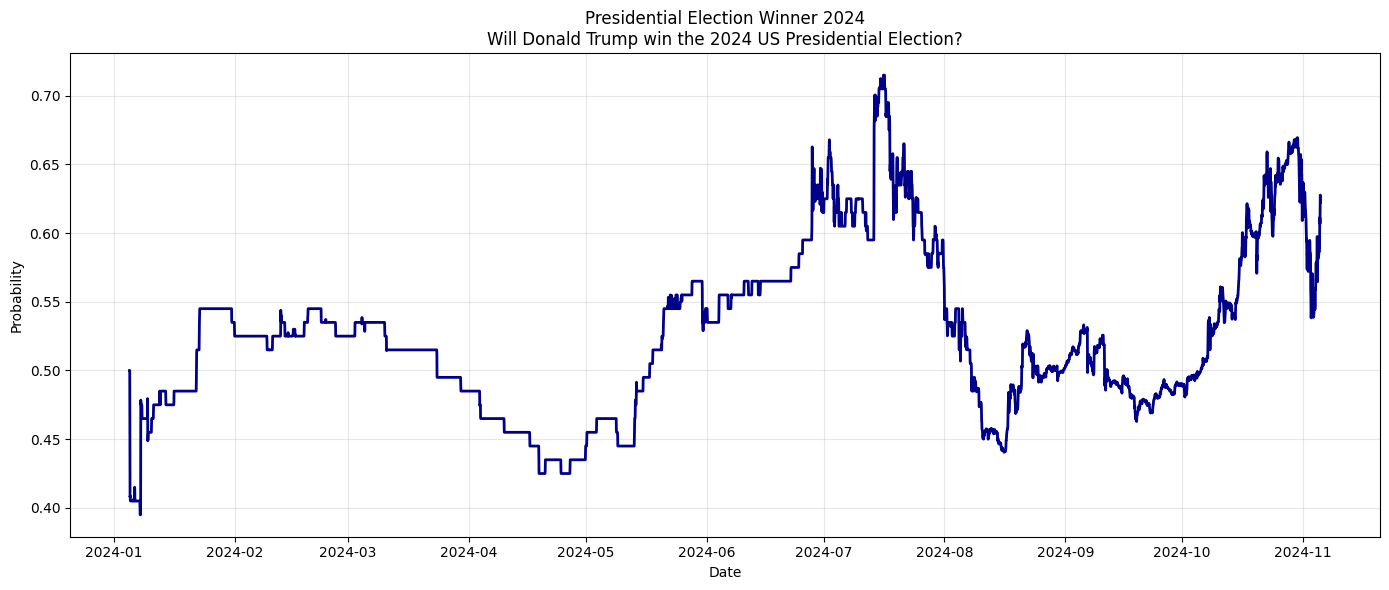

Converting times to ISO: 100%|██████████| 439803/439803 [00:00<00:00, 943079.12point/s]


Data saved to /Users/imakarov/STUDY/ML-News-Market-Analysis/notebooks/../data/presidential-election-winner-2024-6316d.json


Fetching price history: 100%|██████████| 44/44 [00:19<00:00,  2.30chunk/s, points=439715]


Loaded 439,715 price points for: Will Kamala Harris win the 2024 US Presidential El


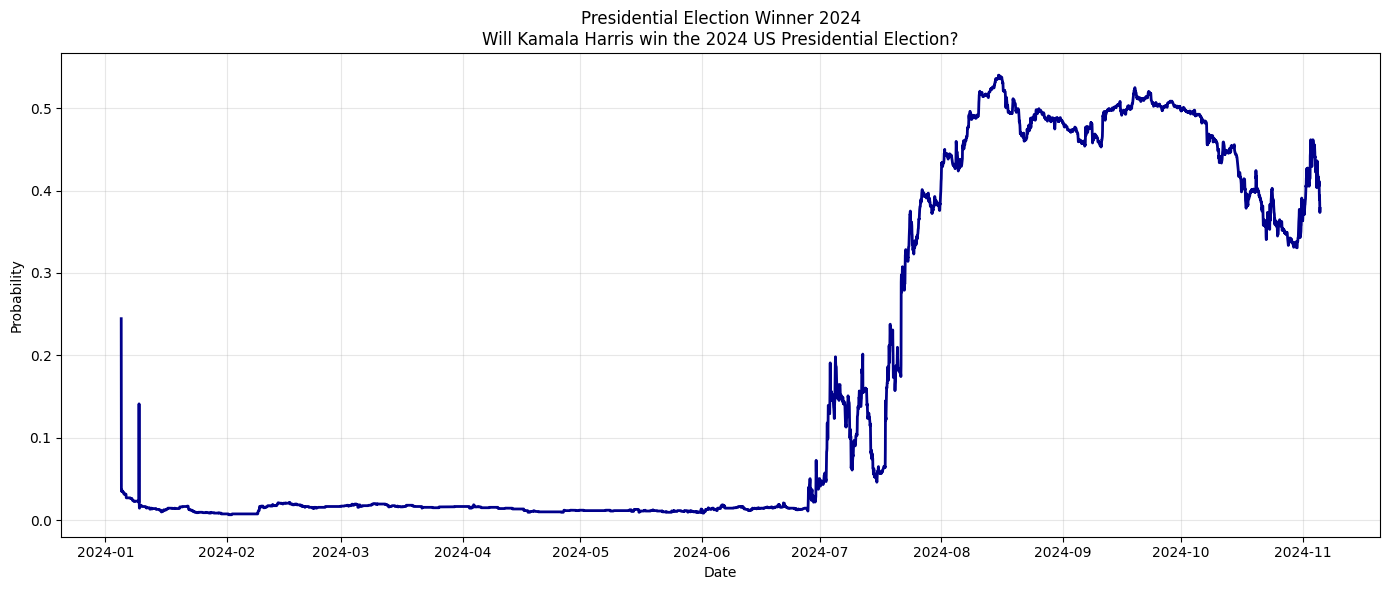

Converting times to ISO: 100%|██████████| 439715/439715 [00:00<00:00, 879931.40point/s]


Data saved to /Users/imakarov/STUDY/ML-News-Market-Analysis/notebooks/../data/presidential-election-winner-2024-8a3b6.json


Fetching price history: 100%|██████████| 26/26 [00:11<00:00,  2.34chunk/s, points=258658]


Loaded 258,658 price points for: Trump ends Ukraine war in first 90 days?


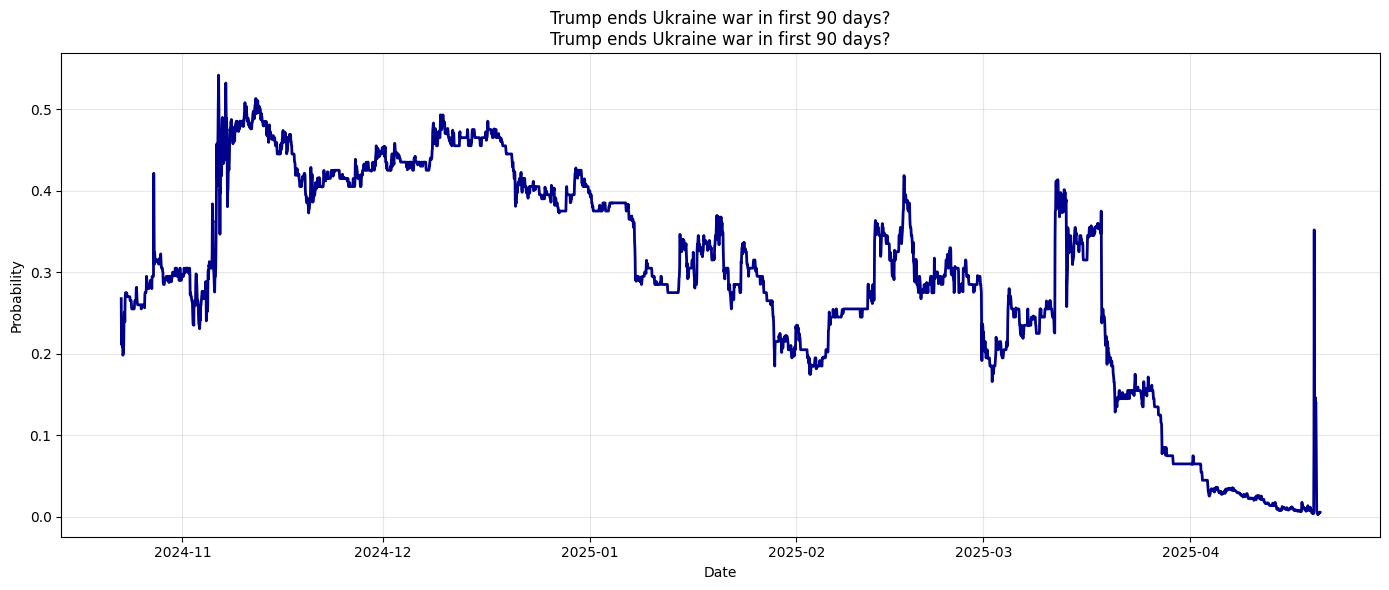

Converting times to ISO: 100%|██████████| 258658/258658 [00:00<00:00, 949510.92point/s]


Data saved to /Users/imakarov/STUDY/ML-News-Market-Analysis/notebooks/../data/trump-wins-ends-ukraine-war-in-90-days-2c482.json


Fetching price history: 100%|██████████| 15/15 [00:06<00:00,  2.40chunk/s, points=147814]

Loaded 147,814 price points for: Israel x Hamas ceasefire before July?


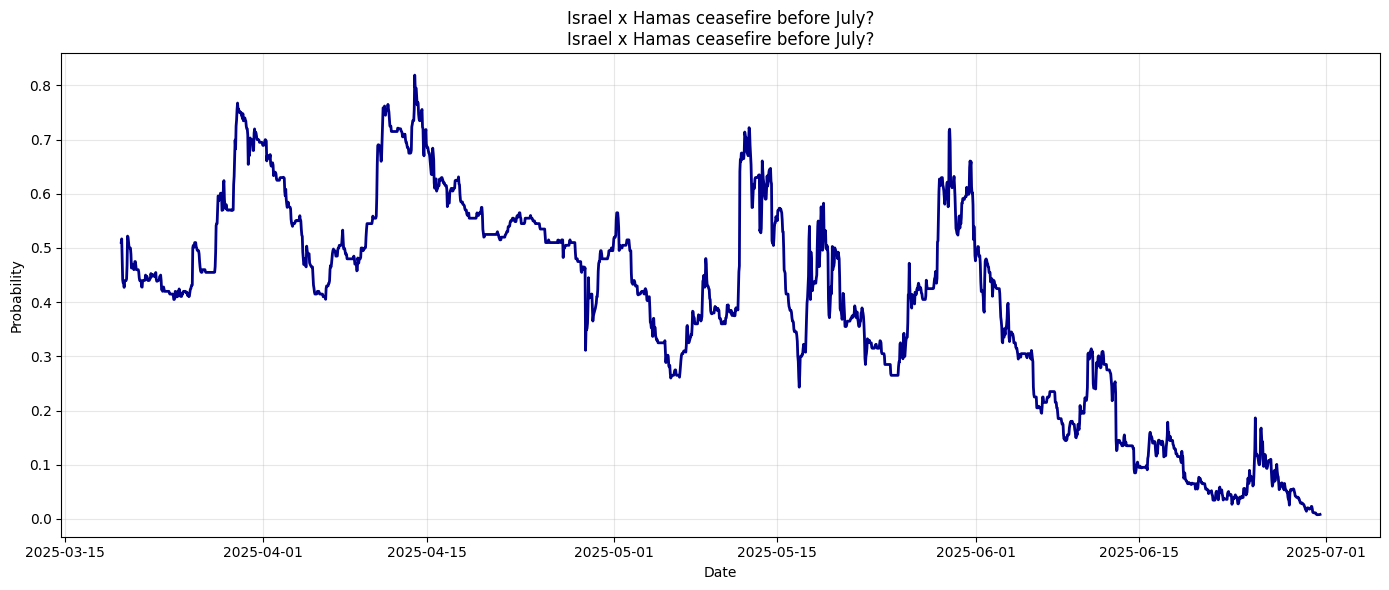

Converting times to ISO: 100%|██████████| 147814/147814 [00:00<00:00, 915659.92point/s]


Data saved to /Users/imakarov/STUDY/ML-News-Market-Analysis/notebooks/../data/israel-x-hamas-ceasefire-before-july-2025-79c05.json


Fetching price history: 33chunk [00:10,  3.27chunk/s, points=181433]                     


Loaded 181,433 price points for: TikTok banned in the US before May 2025?


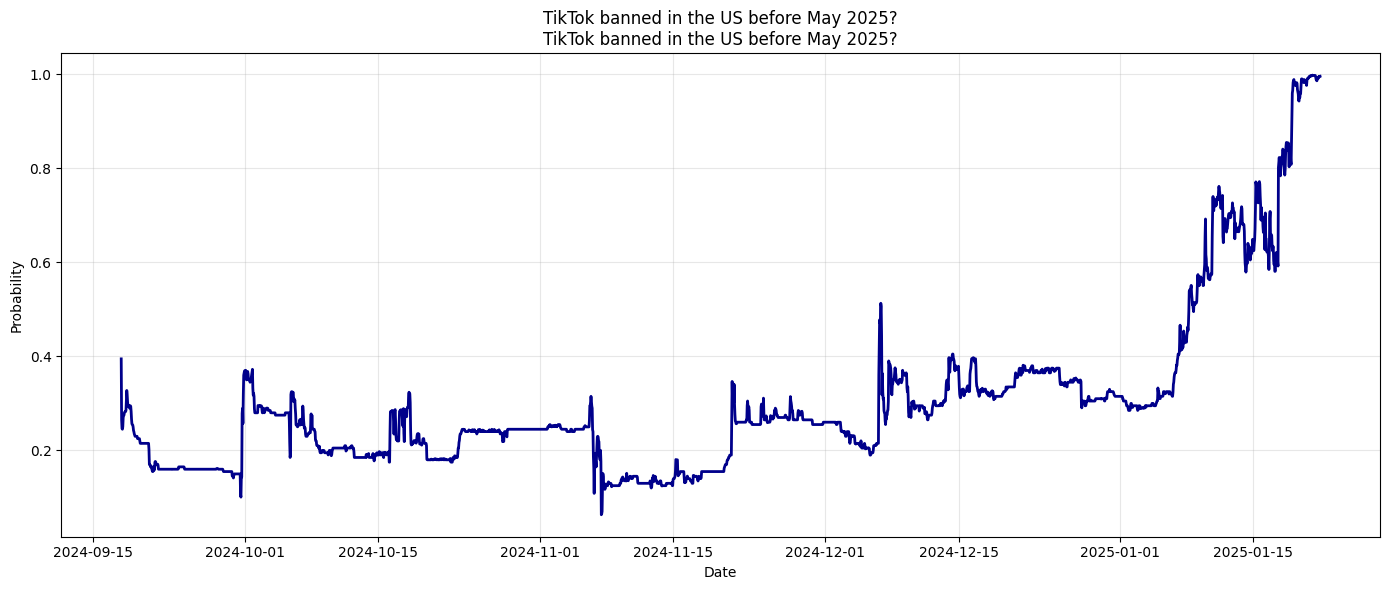

Converting times to ISO: 100%|██████████| 181433/181433 [00:00<00:00, 945495.83point/s]


Data saved to /Users/imakarov/STUDY/ML-News-Market-Analysis/notebooks/../data/tiktok-banned-in-the-us-before-may-2025-52cc0.json


In [3]:
for event_id, token_id in events:
    print(f"{'='*90}")
    data = load_single_market_data(event_id, token_id, show_plot=True)
    save_market_data(data)